In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# **Model**

In [2]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [3]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

In [4]:
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x

In [5]:
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs

In [6]:
inputs = torch.randn((1, 3, 512, 512))
model = build_unet()
y = model(inputs)
print(y.shape)

torch.Size([1, 1, 512, 512])


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2

In [8]:
inputs = torch.randn((1, 3, 512, 512))
model = build_unet()
y = model(inputs)
print(y.shape)

torch.Size([1, 1, 512, 512])


# **TRAINING**

In [9]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [10]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    train_x = sorted(glob(os.path.join(path, "train", "*.tiff")))
    train_y = sorted(glob(os.path.join(path, "train_mask", "*.tif")))

    validate_x = sorted(glob(os.path.join(path, "validate", "*.tiff")))
    validate_y = sorted(glob(os.path.join(path, "validate_mask", "*.tif")))

    return (train_x, train_y), (validate_x, validate_y)

In [11]:
# load_data('/content/drive/MyDrive/Datasets/MIT Buildings Dataset - Shorter version')

In [12]:
# def augment_data(images, masks, save_path, augment=True):
#     size = (512, 512)

#     for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
#         """ Extracting the name """
#         name = x.split("/")[-1].split(".")[0]

#         """ Reading image and mask """
#         x = cv2.imread(x, cv2.IMREAD_COLOR)
#         y = imageio.mimread(y)[0]

#         if augment == True:
#             aug = HorizontalFlip(p=1.0)
#             augmented = aug(image=x, mask=y)
#             x1 = augmented["image"]
#             y1 = augmented["mask"]

#             aug = VerticalFlip(p=1.0)
#             augmented = aug(image=x, mask=y)
#             x2 = augmented["image"]
#             y2 = augmented["mask"]

#             aug = Rotate(limit=45, p=1.0)
#             augmented = aug(image=x, mask=y)
#             x3 = augmented["image"]
#             y3 = augmented["mask"]

#             X = [x, x1, x2, x3]
#             Y = [y, y1, y2, y3]

#         else:
#             X = [x]
#             Y = [y]

#         index = 0
#         for i, m in zip(X, Y):
#             i = cv2.resize(i, size)
#             m = cv2.resize(m, size)

#             tmp_image_name = f"{name}_{index}.png"
#             tmp_mask_name = f"{name}_{index}.png"

#             image_path = os.path.join(save_path, "image", tmp_image_name)
#             mask_path = os.path.join(save_path, "mask", tmp_mask_name)

#             cv2.imwrite(image_path, i)
#             cv2.imwrite(mask_path, m)

#             index += 1

In [13]:
np.random.seed(42)

#""" Load the data """
# data_path = "/content/drive/MyDrive/Datasets/MIT Buildings Dataset"
# (train_x, train_y), (test_x, test_y) = load_data(data_path)

# print(f"Train: {len(train_x)} - {len(train_y)}")
# print(f"Test: {len(test_x)} - {len(test_y)}")

# #""" Create directories to save the augmented data """
# create_dir("/content/drive/MyDrive/Datasets/Retina Blood Vessel - shorter version/new_data/train/image/")
# create_dir("/content/drive/MyDrive/Datasets/Retina Blood Vessel - shorter version/new_data/train/mask/")
# create_dir("/content/drive/MyDrive/Datasets/Retina Blood Vessel - shorter version/new_data/test/image/")
# create_dir("/content/drive/MyDrive/Datasets/Retina Blood Vessel - shorter version/new_data/test/mask/")

# 3#"" Data augmentation """
# augment_data(train_x, train_y, "/content/drive/MyDrive/Datasets/Retina Blood Vessel - shorter version/new_data/train/", augment=True)
# augment_data(test_x, test_y, "/content/drive/MyDrive/Datasets/Retina Blood Vessel - shorter version/new_data/test/", augment=False)

In [14]:
# data_path = "/content/drive/MyDrive/Datasets/MIT Buildings Dataset - Shorter version"
# (train_x, train_y), (test_x, test_y) = load_data(data_path)

In [15]:
import time

def seeding(seed):
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [16]:
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


In [17]:
from torch.utils.data import Dataset

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0 ## (512, 512, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

In [18]:
from torch.utils.data import DataLoader

def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [19]:
H = 256
W = 256
size = (H, W)
batch_size = 2
num_epochs = 20
lr = 1e-4
# checkpoint_path = "/content/drive/MyDrive/Datasets/MIT Buildings Dataset - Shorter version/files/checkpoint.pth"
# create_dir(checkpoint_path)
# os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

checkpoint_path = "/content/checkpoint.pth"  # Changed path
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)  # Create directory if it doesn't exist

data_path = "/content/drive/MyDrive/Datasets/MIT Buildings Dataset - Shorter version"
(train_x, train_y), (validate_x, validate_y) = load_data(data_path)

""" Dataset and loader """
train_dataset = DriveDataset(train_x, train_y)
validate_dataset = DriveDataset(validate_x, validate_y)

train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

validate_loader = DataLoader(
        dataset=validate_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )




device = torch.device('cuda')
model = build_unet()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()




""" Training the model """
best_valid_loss = float("inf")

for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss = evaluate(model, validate_loader, loss_fn, device)

        """ Saving the model """
        if valid_loss < best_valid_loss:
            data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
            print(data_str)

            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
        data_str += f'\tTrain Loss: {train_loss:.3f}\n'
        data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
        print(data_str)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Valid loss improved from inf to 1.6616. Saving checkpoint: /content/checkpoint.pth
Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 1.531
	 Val. Loss: 1.662

Valid loss improved from 1.6616 to 1.5325. Saving checkpoint: /content/checkpoint.pth
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 1.424
	 Val. Loss: 1.532

Valid loss improved from 1.5325 to 1.4614. Saving checkpoint: /content/checkpoint.pth
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 1.313
	 Val. Loss: 1.461

Valid loss improved from 1.4614 to 1.3614. Saving checkpoint: /content/checkpoint.pth
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 1.254
	 Val. Loss: 1.361

Valid loss improved from 1.3614 to 1.2582. Saving checkpoint: /content/checkpoint.pth
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 1.179
	 Val. Loss: 1.258

Valid loss improved from 1.2582 to 1.2369. Saving checkpoint: /content/checkpoint.pth
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 1.131
	 Val. Loss: 1.237

Valid loss improved from 1.2369 to 1.1841. Saving checkpoint: /content/c

# **Test the Model**

In [46]:
def load_test_data(path):
    test_x = sorted(glob(os.path.join(path, "test", "*.tiff")))
    test_y = sorted(glob(os.path.join(path, "test_mask", "*.tif")))

    return (test_x, test_y)

path = "/content/drive/MyDrive/Datasets/MIT Buildings Dataset - Shorter version"
(test_x, test_y) = load_test_data(path)

test_dataset = DriveDataset(test_x, test_y)

test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )


test_loss = evaluate(model, test_loader, loss_fn, device)

print (f'\t Mean Test Loss: {test_loss:.3f}\n')

	 Mean Test Loss: 0.997



# how accurate if DICE loss is 0.9 ?
A DICE loss of 0.9 indicates high accuracy in your model's performance, especially for tasks like image segmentation. The DICE coefficient (or DICE loss) ranges from 0 to 1, where 1 represents perfect overlap between the predicted and ground truth segments2.

In practical terms, a DICE score of 0.9 means your model is correctly identifying 90% of the relevant areas in the images. This is generally considered very good, especially in fields like medical imaging where precise segmentation is crucial

In [31]:
img = cv2.imread(test_x[3])
img = cv2.resize(img, size)
img = img/255.0
img = np.transpose(img, (2, 0, 1))
img = img.astype(np.float32)
img = np.expand_dims(img, axis=0)
img = torch.from_numpy(img)
img = img.to(device=device, dtype=torch.float32)



In [32]:
# img

In [33]:
pred = model (img)

In [34]:
pred = pred.cpu()
pred = pred.detach().numpy()
pred = np.squeeze(pred, axis=0)
pred = pred > 0.5
pred = pred.astype(np.int32)



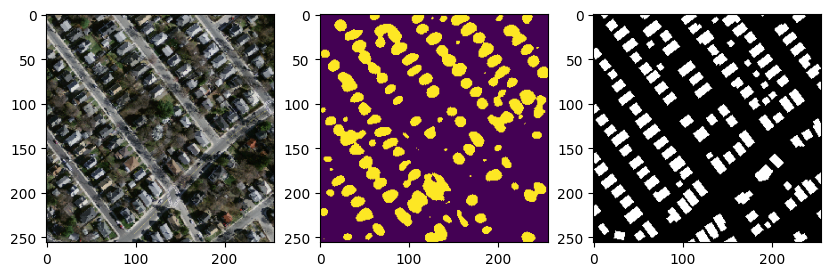

In [35]:
pred2 = pred.reshape(256,256,1)
pred2.shape

img = cv2.imread(test_x[3] )
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, size)


msk = cv2.imread(test_y[3])
msk = cv2.resize(msk, size)
msk = msk.astype(np.float32)

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(pred2)
plt.subplot(1,3,3)
plt.imshow(msk)

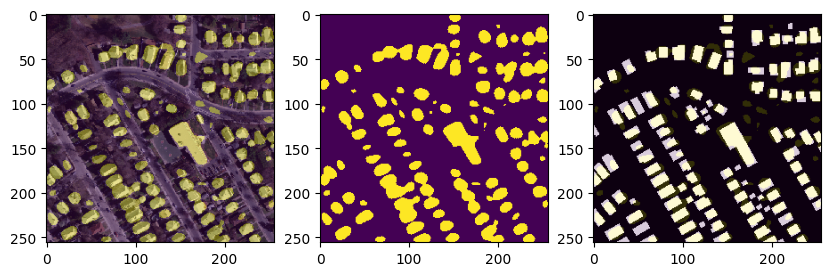

In [36]:
img = cv2.imread(test_x[4])
img = cv2.resize(img, size)
img = img/255.0
img = np.transpose(img, (2, 0, 1))
img = img.astype(np.float32)
img = np.expand_dims(img, axis=0)
img = torch.from_numpy(img)
img = img.to(device=device, dtype=torch.float32)

pred = model (img)

pred = pred.cpu()
pred = pred.detach().numpy()
pred = np.squeeze(pred, axis=0)
pred = pred > 0.5
pred = pred.astype(np.int32)

pred2 = pred.reshape(256,256,1)
pred2.shape

msk = cv2.imread(test_y[4])
msk = cv2.resize(msk, size)
msk = msk.astype(np.float32)

img = cv2.imread(test_x[4] )
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, size)

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.imshow(pred2, alpha=0.4)
plt.subplot(1,3,2)
plt.imshow(pred2)
plt.subplot(1,3,3)
plt.imshow(msk)
plt.imshow(pred2, alpha=0.2)

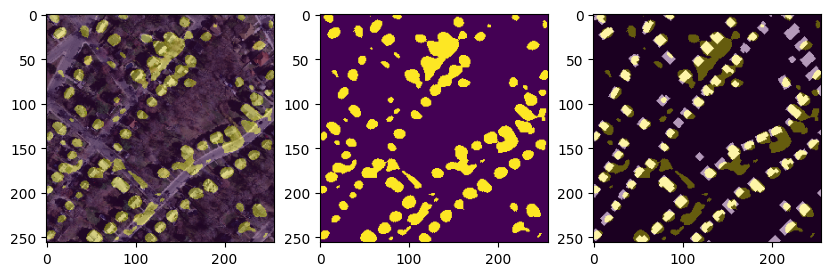

In [37]:
img = cv2.imread(test_x[6])
img = cv2.resize(img, size)
img = img/255.0
img = np.transpose(img, (2, 0, 1))
img = img.astype(np.float32)
img = np.expand_dims(img, axis=0)
img = torch.from_numpy(img)
img = img.to(device=device, dtype=torch.float32)

pred = model (img)

pred = pred.cpu()
pred = pred.detach().numpy()
pred = np.squeeze(pred, axis=0)
pred = pred > 0.5
pred = pred.astype(np.int32)

pred2 = pred.reshape(256,256,1)
pred2.shape

msk = cv2.imread(test_y[6])
msk = cv2.resize(msk, size)
msk = msk.astype(np.float32)

img = cv2.imread(test_x[6] )
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, size)

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.imshow(pred2, alpha=0.4)
plt.subplot(1,3,2)
plt.imshow(pred2)
plt.subplot(1,3,3)
plt.imshow(msk)
plt.imshow(pred2, alpha=0.4)

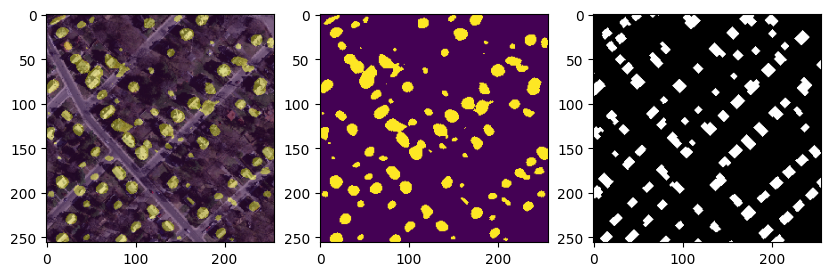

In [38]:
img = cv2.imread(test_x[7])
img = cv2.resize(img, size)
img = img/255.0
img = np.transpose(img, (2, 0, 1))
img = img.astype(np.float32)
img = np.expand_dims(img, axis=0)
img = torch.from_numpy(img)
img = img.to(device=device, dtype=torch.float32)

pred = model (img)

pred = pred.cpu()
pred = pred.detach().numpy()
pred = np.squeeze(pred, axis=0)
pred = pred > 0.5
pred = pred.astype(np.int32)

pred2 = pred.reshape(256,256,1)
pred2.shape

msk = cv2.imread(test_y[7])
msk = cv2.resize(msk, size)
msk = msk.astype(np.float32)

img = cv2.imread(test_x[7] )
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, size)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.imshow(pred2, alpha=0.4)
plt.subplot(1,3,2)
plt.imshow(pred2)
plt.subplot(1,3,3)
plt.imshow(msk)

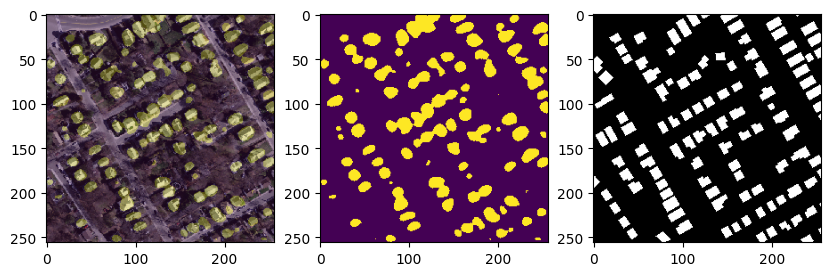

In [39]:
img = cv2.imread(test_x[8])
img = cv2.resize(img, size)
img = img/255.0
img = np.transpose(img, (2, 0, 1))
img = img.astype(np.float32)
img = np.expand_dims(img, axis=0)
img = torch.from_numpy(img)
img = img.to(device=device, dtype=torch.float32)

pred = model (img)

pred = pred.cpu()
pred = pred.detach().numpy()
pred = np.squeeze(pred, axis=0)
pred = pred > 0.5
pred = pred.astype(np.int32)

pred2 = pred.reshape(256,256,1)
pred2.shape

msk = cv2.imread(test_y[8])
msk = cv2.resize(msk, size)
msk = msk.astype(np.float32)

img = cv2.imread(test_x[8] )
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, size)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.imshow(pred2, alpha=0.3)
plt.subplot(1,3,2)
plt.imshow(pred2)
plt.subplot(1,3,3)
plt.imshow(msk)
# plt.imshow(pred2, alpha=0.3)

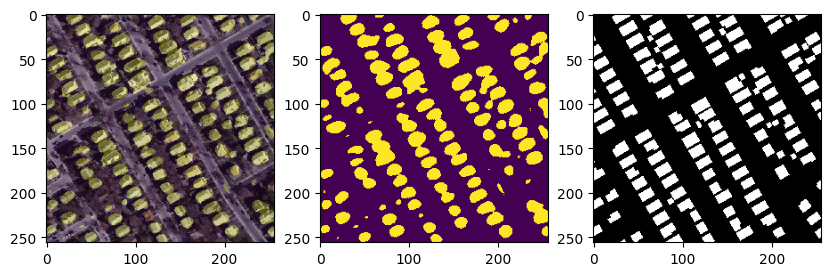

In [40]:
img = cv2.imread(test_x[9])
img = cv2.resize(img, size)
img = img/255.0
img = np.transpose(img, (2, 0, 1))
img = img.astype(np.float32)
img = np.expand_dims(img, axis=0)
img = torch.from_numpy(img)
img = img.to(device=device, dtype=torch.float32)

pred = model (img)

pred = pred.cpu()
pred = pred.detach().numpy()
pred = np.squeeze(pred, axis=0)
pred = pred > 0.5
pred = pred.astype(np.int32)

pred2 = pred.reshape(256,256,1)
pred2.shape

msk = cv2.imread(test_y[9])
msk = cv2.resize(msk, size)
msk = msk.astype(np.float32)

img = cv2.imread(test_x[9] )
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, size)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.imshow(pred2, alpha=0.3)
plt.subplot(1,3,2)
plt.imshow(pred2)
plt.subplot(1,3,3)
plt.imshow(msk)
# plt.imshow(pred2, alpha=0.3)

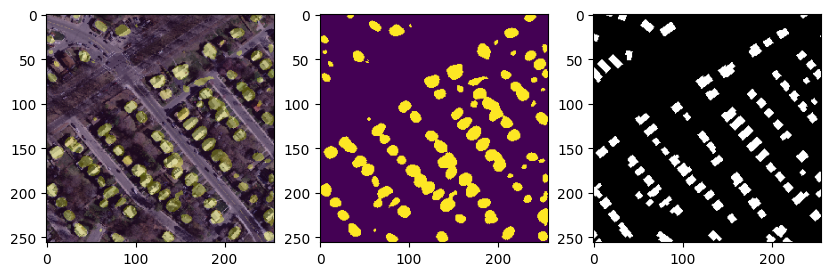

In [44]:
img = cv2.imread(test_x[1])
img = cv2.resize(img, size)
img = img/255.0
img = np.transpose(img, (2, 0, 1))
img = img.astype(np.float32)
img = np.expand_dims(img, axis=0)
img = torch.from_numpy(img)
img = img.to(device=device, dtype=torch.float32)

pred = model (img)

pred = pred.cpu()
pred = pred.detach().numpy()
pred = np.squeeze(pred, axis=0)
pred = pred > 0.5
pred = pred.astype(np.int32)

pred2 = pred.reshape(256,256,1)
pred2.shape

msk = cv2.imread(test_y[1])
msk = cv2.resize(msk, size)
msk = msk.astype(np.float32)

img = cv2.imread(test_x[1] )
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, size)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.imshow(pred2, alpha=0.3)
plt.subplot(1,3,2)
plt.imshow(pred2)
plt.subplot(1,3,3)
plt.imshow(msk)
# plt.imshow(pred2, alpha=0.3)